In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from data.constants import *
from data.utils import AugmentedTonesDataset, GetDevice
from models.BasicCNN import ChineseTonesDataset
from models.ResNet import ResNet18

In [3]:
X = np.load(os.path.join(DATA_DIR, 'features.npy'))
y = np.load(os.path.join(DATA_DIR, 'labels.npy')) # will need to change to tone_labels when feature_extraction is rerun

X = torch.FloatTensor(X)
y = torch.LongTensor(y)

y = y - 1 # need to do this to make sure the values are within the range for CrossEntropy

In [4]:
print(f"X.shape - pre: \n\t{X.shape}")
X = X.unsqueeze(1)
print(f"X.shape - post: \n\t{X.shape}")
num_classes = len(torch.unique(y))
print(f"number of classes: {num_classes}")

X.shape - pre: 
	torch.Size([14931, 13, 237])
X.shape - post: 
	torch.Size([14931, 1, 13, 237])
number of classes: 4


In [11]:
torch.unique(y, return_counts=True)

(tensor([0, 1, 2, 3]), tensor([3736, 1244, 4986, 4965]))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

train_dataset = ChineseTonesDataset(X_train, y_train)
test_dataset = ChineseTonesDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
model = ResNet18(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
device = GetDevice()
model = model.to(device)

In [10]:
print(device)

mps


### Training Loop

In [11]:
for epoch in range(10):
  running_loss = 0.0
  for i, data in tqdm(enumerate(train_dataloader)):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'Epoch {epoch} loss: {running_loss / len(train_dataloader)}')
    

327it [00:35,  9.20it/s]


Epoch 0 loss: 0.7786912609130965


327it [00:29, 10.99it/s]


Epoch 1 loss: 0.4867260595982957


327it [00:30, 10.58it/s]


Epoch 2 loss: 0.3922390146722123


327it [00:33,  9.80it/s]


Epoch 3 loss: 0.3319875907141499


327it [00:32, 10.06it/s]


Epoch 4 loss: 0.2642897769170799


327it [00:31, 10.47it/s]


Epoch 5 loss: 0.21420512542082992


327it [00:30, 10.72it/s]


Epoch 6 loss: 0.15187125709990112


327it [00:30, 10.74it/s]


Epoch 7 loss: 0.14387938798909342


327it [00:30, 10.72it/s]


Epoch 8 loss: 0.09010876625753506


327it [00:30, 10.67it/s]

Epoch 9 loss: 0.06422631882148189


- 327it [00:35,  9.20it/s]
- Epoch 0 loss: 0.7786912609130965
- 327it [00:29, 10.99it/s]
- Epoch 1 loss: 0.4867260595982957
- 327it [00:30, 10.58it/s]
- Epoch 2 loss: 0.3922390146722123
- 327it [00:33,  9.80it/s]
- Epoch 3 loss: 0.3319875907141499
- 327it [00:32, 10.06it/s]
- Epoch 4 loss: 0.2642897769170799
- 327it [00:31, 10.47it/s]
- Epoch 5 loss: 0.21420512542082992
- 327it [00:30, 10.72it/s]
- Epoch 6 loss: 0.15187125709990112
- 327it [00:30, 10.74it/s]
- Epoch 7 loss: 0.14387938798909342
- 327it [00:30, 10.72it/s]
- Epoch 8 loss: 0.09010876625753506
- 327it [00:30, 10.67it/s]
- Epoch 9 loss: 0.06422631882148189

In [13]:
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
  for features_batch, labels_batch in test_dataloader:
    features_batch = features_batch.to(device)
    labels_batch = labels_batch.to(device)

    outputs = model(features_batch)
    _, predicted = torch.max(outputs, 1)
    total += labels_batch.size(0)
    correct += (predicted == labels_batch).sum().item()

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels_batch.cpu().numpy())

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 83.44%


current acc: 83.44%

## Adding online augmentation to training loop

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

train_dataset = AugmentedTonesDataset(X_train, y_train, augment_prob=0.5)
test_dataset = AugmentedTonesDataset(X_test, y_test, augment_prob=0.5)

train_dataloader = DataLoader(
  train_dataset, 
  batch_size=32, 
  shuffle=True,
  num_workers=4,
  persistent_workers=True,
  prefetch_factor=2
  )
test_dataloader = DataLoader(
  test_dataset,
  batch_size=32, 
  shuffle=True,
  num_workers=4,
  persistent_workers=True,
  prefetch_factor=2
  )

In [6]:
model = ResNet18(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = GetDevice()
model = model.to(device)

In [7]:
for epoch in range(10):
  running_loss = 0.0
  for i, data in tqdm(enumerate(train_dataloader)):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'Epoch {epoch} loss: {running_loss / len(train_dataloader)}')
    

327it [00:30, 10.86it/s]


Epoch 0 loss: 0.9135541436504516


327it [00:30, 10.83it/s]


Epoch 1 loss: 0.6671809866705437


327it [00:30, 10.64it/s]


Epoch 2 loss: 0.5934768070321564


327it [00:31, 10.49it/s]


Epoch 3 loss: 0.5256371311729472


327it [00:30, 10.63it/s]


Epoch 4 loss: 0.48990196016950344


327it [00:30, 10.66it/s]


Epoch 5 loss: 0.45108620899897467


327it [00:30, 10.70it/s]


Epoch 6 loss: 0.41809811504608996


327it [00:30, 10.67it/s]


Epoch 7 loss: 0.38428021119822053


327it [00:30, 10.70it/s]


Epoch 8 loss: 0.3626626086982383


327it [00:30, 10.56it/s]

Epoch 9 loss: 0.3268409728639352


In [8]:
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
  for features_batch, labels_batch in test_dataloader:
    features_batch = features_batch.to(device)
    labels_batch = labels_batch.to(device)

    outputs = model(features_batch)
    _, predicted = torch.max(outputs, 1)
    total += labels_batch.size(0)
    correct += (predicted == labels_batch).sum().item()

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels_batch.cpu().numpy())

accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 78.37%


In [9]:
# Print a detailed classification report
print(classification_report(all_labels, all_preds))

# Print the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)


              precision    recall  f1-score   support

           0       0.69      0.84      0.76      1123
           1       0.95      0.48      0.64       373
           2       0.79      0.85      0.82      1492
           3       0.85      0.75      0.80      1492

    accuracy                           0.78      4480
   macro avg       0.82      0.73      0.75      4480
weighted avg       0.80      0.78      0.78      4480

Confusion Matrix:
 [[ 940    4  116   63]
 [  82  180   55   56]
 [ 141    1 1269   81]
 [ 195    4  171 1122]]


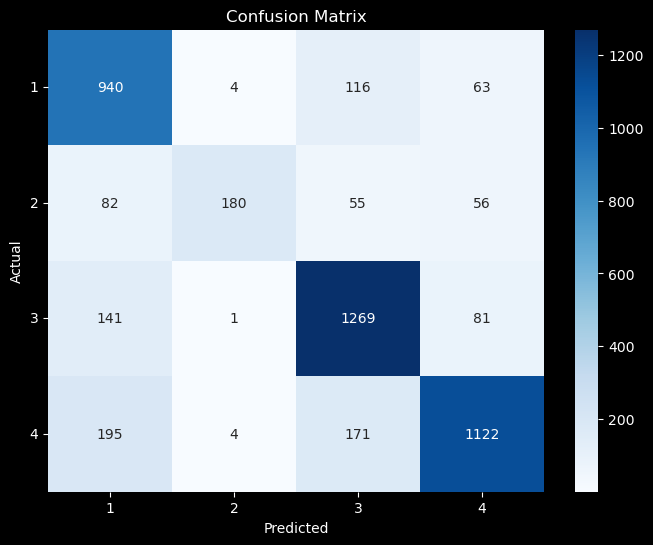

In [10]:
tones = [num + 1 for num in range(num_classes)]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=tones, yticklabels=tones)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.show()


## ON THE HELLA AUGMENTED DATA

In [ ]:
X_train = np.load(os.path.join(DATA_DIR, 'train_features.npy'))
X_test = np.load(os.path.join(DATA_DIR, 'test_features.npy')) 
y_train = np.load(os.path.join(DATA_DIR, 'train_labels.npy'))
y_test = np.load(os.path.join(DATA_DIR, 'test_labels.npy'))

In [ ]:
train_dataset = AugmentedTonesDataset(X_train, y_train, augment_prob=0.5)
test_dataset = AugmentedTonesDataset(X_test, y_test, augment_prob=0.5)

train_dataloader = DataLoader(
  train_dataset, 
  batch_size=32, 
  shuffle=True,
  num_workers=4,
  persistent_workers=True,
  prefetch_factor=2
  )
test_dataloader = DataLoader(
  test_dataset,
  batch_size=32, 
  shuffle=True,
  num_workers=4,
  persistent_workers=True,
  prefetch_factor=2
  )

In [ ]:
model = ResNet18(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = GetDevice()
model = model.to(device)

In [ ]:
for epoch in range(10):
  running_loss = 0.0
  for i, data in tqdm(enumerate(train_dataloader)):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'Epoch {epoch} loss: {running_loss / len(train_dataloader)}')
    